# Visuals for experimental design + results

# Preparations

## Imports
Python-psignifit: https://github.com/wichmann-lab/python-psignifit

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from matplotlib import animation
import pandas as pd
import psignifit as ps
import pickle
import scipy.io

# Read functions from parent folder:
sys.path.append('../experiment')
from params import stim_params as sparams
from params import exp_params as eparams

sys.path.append('../simulations')
from functions import load_all_data, plotPsych, naka_rushton, create_loggabor_fft, create_noise, create_edge

## Parameters

In [72]:
v = sparams["stim_size"]                  # visual extent in deg
ppd = sparams["ppd"]                      # spatial resolution (pixels per deg)
mean_lum = sparams["mean_lum"]            # mean luminance in cd/m**2
edge_widths = sparams["edge_widths"]      # of Cornsweet edges in deg
edge_exponent = sparams["edge_exponent"]  # of Cornsweet edges
noise_types = sparams["noise_types"]
rms_noise = sparams["noise_contrast"]     # rms contrast of noise masks
rms_edge = 0.02                           # edge contrast for visuals
trans_amount = eparams["trans_amount"]

plot_sensitivity = False                 # plot thresholds or sensitivity
rotate = True                            # rotate stimuli 90 degrees

# Calculate spatial axis in pixels:
vextent = [-v/2., v/2., v/2., -v/2.]
x = np.arange(vextent[0]*ppd, vextent[1]*ppd, 1.)
nX = len(x)

# Calculate spatial frequency axis in cpd:
fs = np.fft.fftshift(np.fft.fftfreq(int(nX), d=1./ppd))
fx, fy = np.meshgrid(fs, fs)
fs_1d = fs[int(nX/2)::]
fextent = (fs[0], fs[-1], fs[0], fs[-1])

# Min and max intensities for plotting:
vmin, vmax = 0, mean_lum*2.

## Helper functions

In [4]:
# Helper function to calculate DC-free power from stimulus
def spectral_power(stimulus):
    power = np.abs(np.fft.fftshift(np.fft.fftn(stimulus - stimulus.mean()))) ** 2.
    return power


def calc_mean_tf(tprof, pps):
    # Calculate fft:
    tprof_fft = np.abs(np.fft.fftshift(np.fft.fft(tprof)))**2.

    # Get temporal frequency axis in Hz:
    T = len(tprof)
    ft = np.fft.fftshift(np.fft.fftfreq(int(T), d=1./pps))
    
    # Get values for positive frequencies:
    ft_pos = ft[int(T/2.)::]
    tprof_fftpos = tprof_fft[int(T/2.)::]
    
    # Find and return tf at which power is closest to mean power:
    idx = (np.abs(tprof_fftpos - tprof_fftpos.mean())).argmin()
    return ft_pos[idx]


def show_video(vid_arr, vmin=vmin, vmax=vmax, cmap='gray'):
    fig = plt.figure(figsize=(4, 4))
    im = plt.imshow(vid_arr[:,:,0], cmap="gray", vmin=vmin, vmax=vmax)
    plt.axis('off')

    def init():
        im.set_data(vid_arr[:,:,0])

    def animate(i):
        im.set_data(vid_arr[:,:,i])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=vid_arr.shape[2], interval=50)
    return anim


# Reformat data to psignifit requirements (x, ncorrect, ntrials)
def reformat_data(data, n, e, vp='all', session=None):
    if session != None and vp != "all":
        data = data[data["session"] == session]

    # Get data from one condition
    data_cond = data[(data["noise"] == n) & (data["edge_width"] == e)]

    # Get data from all or selected observer
    if vp == 'all':
        data_vp = data_cond
    else:
        data_vp = data_cond[data_cond["vp"] == vp]
    
    for s in range(2):
        contrasts = np.unique(data_vp["edge_contrast"])
        n_correct = np.zeros(len(contrasts))
        n_trials = np.zeros(len(contrasts))
        for i in range(len(contrasts)):
            data_correct = data_vp[data_vp["edge_contrast"] == contrasts[i]]["correct"]
            n_correct[i] = np.sum(data_correct)
            n_trials[i] = len(data_correct)
        p_correct = n_correct / n_trials
    return np.array([contrasts, n_correct, n_trials]).transpose()


# Reformat data to psignifit requirements (x, ncorrect, ntrials)
def reformat_data_all(data, n, e):
    # Get data from one condition
    data_cond = data[(data["noise"] == n) & (data["edge_width"] == e)]
    
    vps = np.unique(data_cond["vp"])
    psi_data_all = np.empty([0,3])
    
    for vp in vps:
        data_vp = data_cond[data_cond["vp"] == vp]
    
        for s in range(2):
            data_sess = data_vp[data_vp["session"] == s]
            contrasts = np.unique(data_sess["edge_contrast"])
            n_correct = np.zeros(len(contrasts))
            n_trials = np.zeros(len(contrasts))
            for i in range(len(contrasts)):
                data_correct = data_sess[data_sess["edge_contrast"] == contrasts[i]]["correct"]
                n_correct[i] = np.sum(data_correct)
                n_trials[i] = len(data_correct)
            p_correct = n_correct / n_trials

            psi_data = np.array([contrasts, n_correct, n_trials]).transpose()
            psi_data_all = np.append(psi_data_all, psi_data, axis=0)
    return psi_data_all

# Spatiotemporal csf functions taken from Kelly1979:
def st_csf(sfs, tf):
    # Workaround for sf=0 to avoid dividing by zero
    sfs2 = np.copy(sfs)
    idx = np.where(sfs2 == 0.)
    sfs2[sfs == 0.] = 1.
    
    # Calculate contrast sensitivity function:
    v = tf / sfs2  # Calculate "velocity" needed for formula
    k = 6.1 + 7.3 * np.abs(np.log10(v/3.))**3.
    csfSens = k * v * (2.*np.pi*sfs2)**2. * np.exp((-4.*np.pi*sfs2) / (45.9 / (v + 2.)))
    csfThresh = 1. / csfSens
    
    if len(idx):
        csfThresh[idx] = 0.
        csfSens[idx] = 0.
    return csfThresh, csfSens

# Stimuli

## Noise masks

In [82]:
# Create noise masks
noises = []
n_noises = len(noise_types)
for ni, n in enumerate(noise_types):
    noises.append(create_noise(n, sparams) + mean_lum)

In [ ]:
# Rename noises for visualizations
noise_types = [w.replace('pink1', 'pink') for w in noise_types]
noise_types = [w.replace('pink2', 'brown') for w in noise_types]
noise_types = [w.replace('narrow0.5', 'LSF-noise') for w in noise_types]
noise_types = [w.replace('narrow3', 'MSF-noise') for w in noise_types]
noise_types = [w.replace('narrow9', 'HSF-noise') for w in noise_types]

print(noise_types)

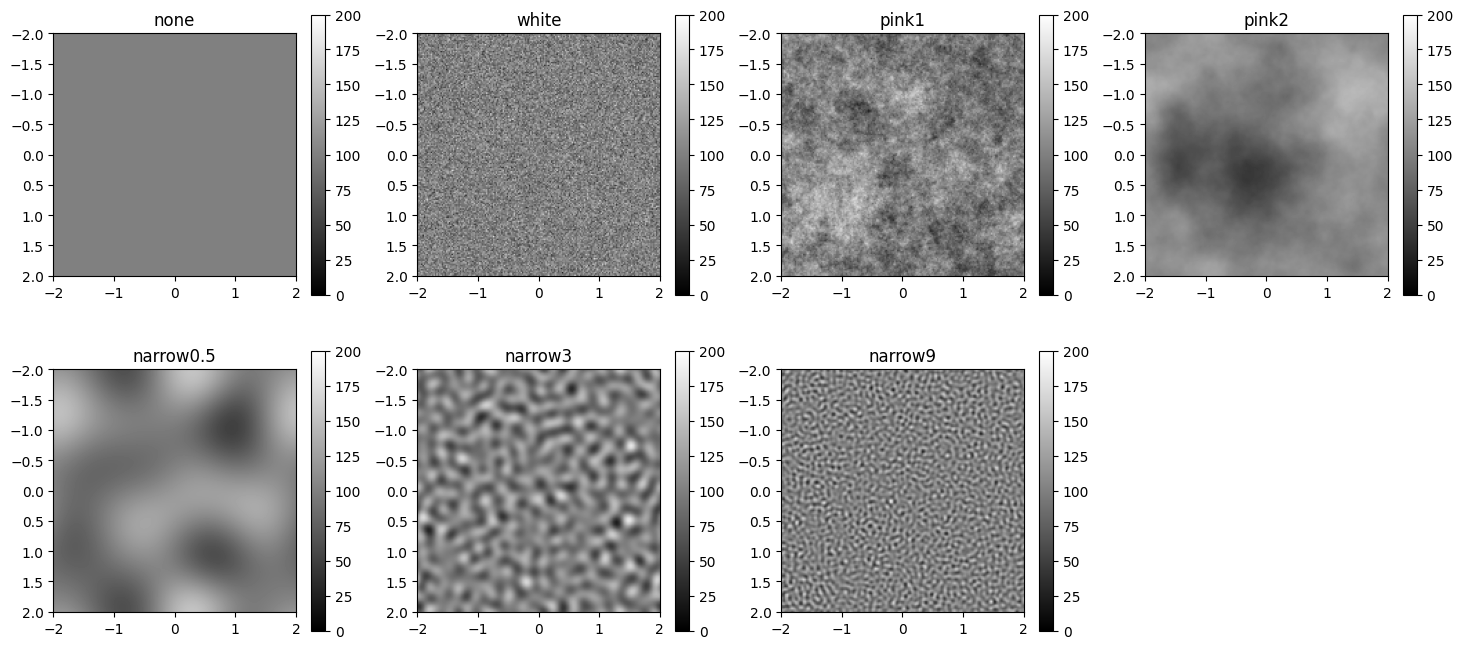

In [83]:
# Plot noise masks:
n, m = 2, 4
plt.figure(figsize=(18, 8))
for i in range(n_noises):
    plt.subplot(n, m, i+1)
    plt.imshow(noises[i], cmap='gray', extent=vextent, vmin=vmin, vmax=vmax)
    plt.title(noise_types[i]), plt.colorbar()
plt.show()

## Cornsweet edges

In [85]:
# Create edges
edge1 = create_edge(rms_edge, edge_widths[0], sparams)
edge2 = create_edge(rms_edge, edge_widths[1], sparams)
edge3 = create_edge(rms_edge, edge_widths[2], sparams)

if rotate:
    edge1 = np.rot90(edge1)
    edge2 = np.rot90(edge2)
    edge3 = np.rot90(edge3)

# Make a list for plotting
edges = [edge1, edge2, edge3]
edge_types = ["HSF-edge", "MSF-edge", "LSF-edge"]
n_edges = len(edges)

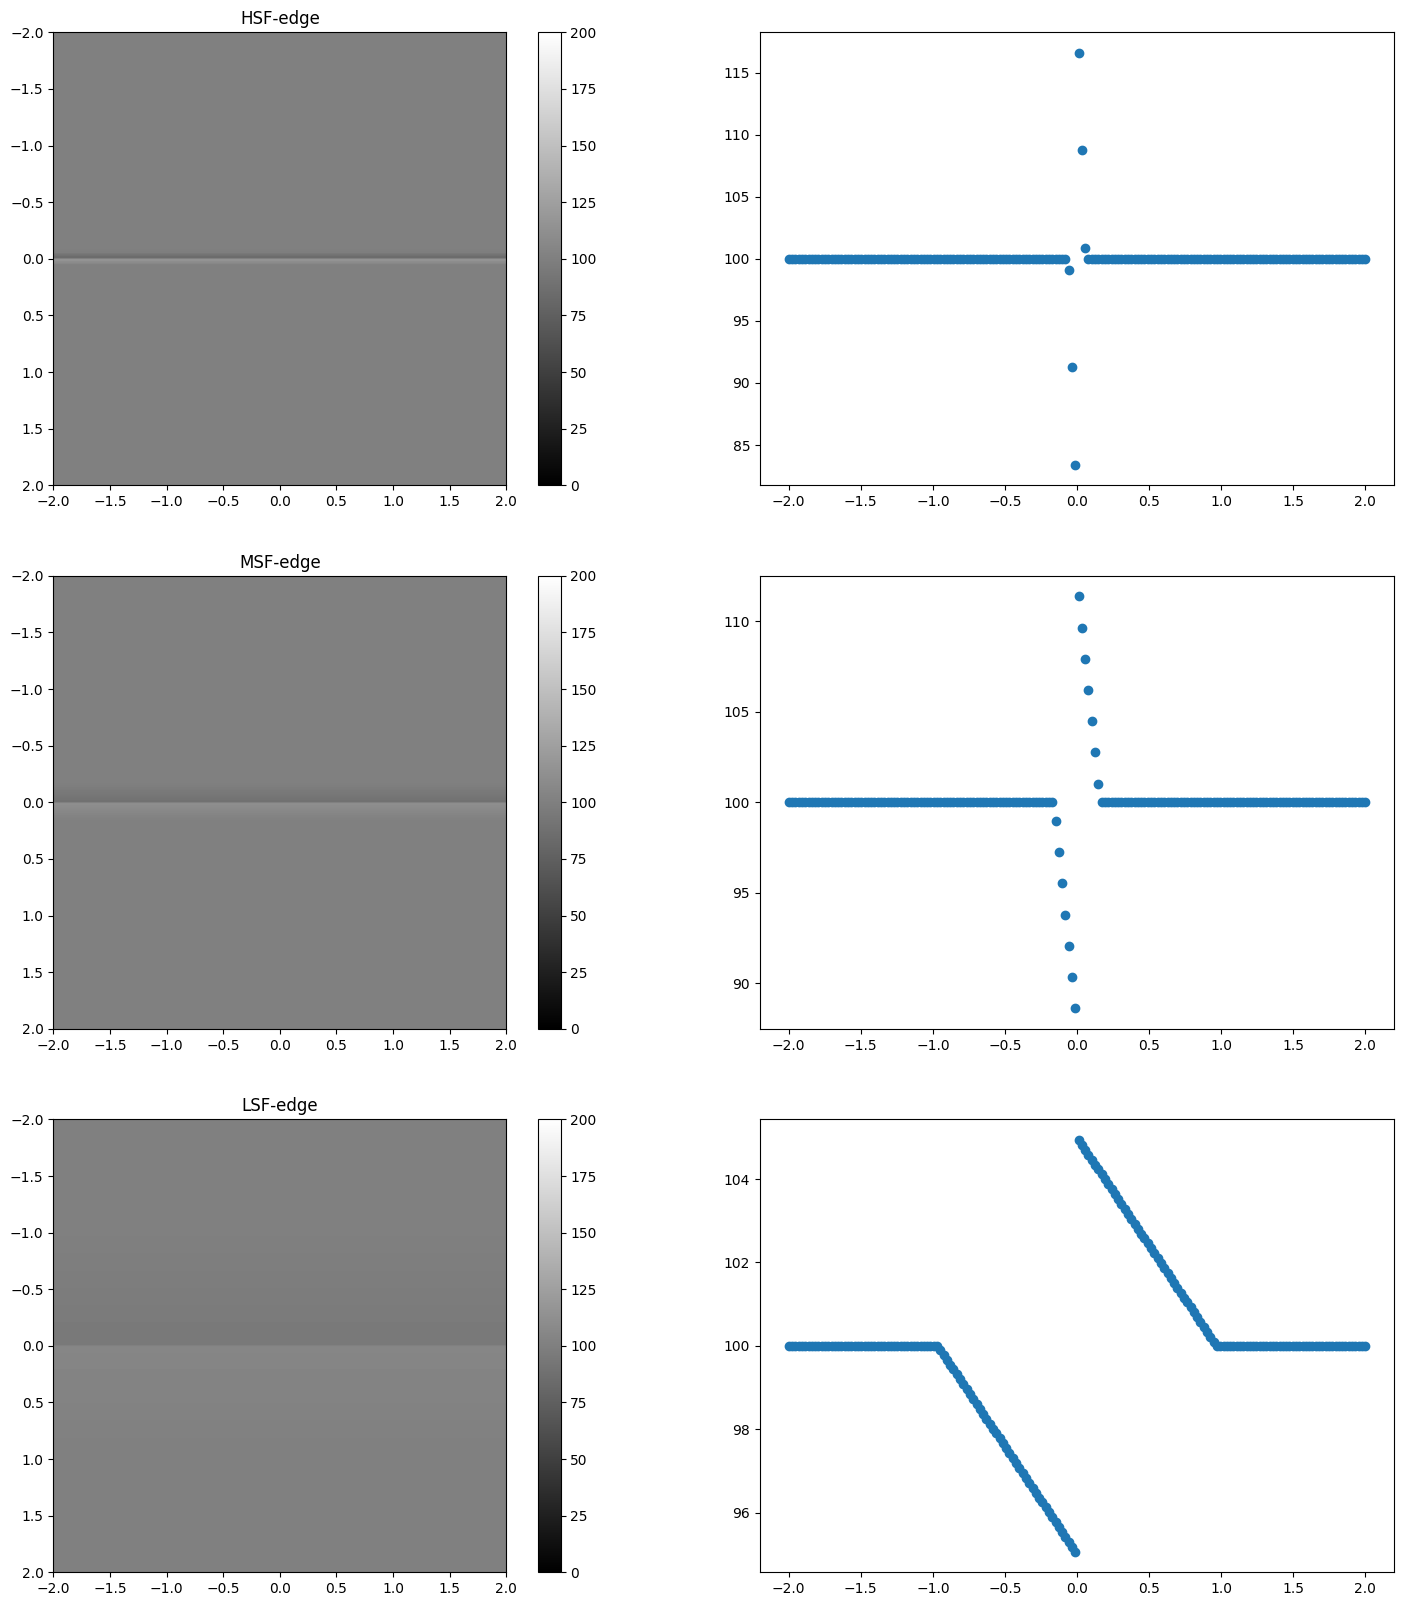

In [86]:
xcut = np.linspace(-v/2, v/2, nX)

# Plot edges
n, m = 3, 2
plt.figure(figsize=(18, 20))
for i in range(n_edges):
    plt.subplot(n, m, (i*2)+1)
    plt.imshow(edges[i], cmap='gray', extent=vextent, vmin=vmin, vmax=vmax)
    plt.title(edge_types[i]), plt.colorbar()
              
    # Luminance profile
    plt.subplot(n, m, (i*2)+2)
    if rotate:
        plt.plot(xcut, edges[i][:, int(nX/2)], 'o')
    else:
        plt.plot(xcut, edges[i][int(nX/2), :], 'o')
plt.show()

In [ ]:
# Plot all noise-masked stimuli
fig, axes = plt.subplots(len(noises), len(edges), figsize=(14, 32), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.001, wspace=0.001)
for i in range(len(noises)):
    lumprofile1 = (edges[0][:, int(nX/2)] - mean_lum) / 30
    lumprofile2 = (edges[1][:, int(nX/2)] - mean_lum) / 30
    lumprofile3 = (edges[2][:, int(nX/2)] - mean_lum) / 30

    axes[i, 0].imshow(edges[0]+noises[i]-mean_lum, cmap='gray', extent=vextent, vmin=vmin, vmax=vmax)
    axes[i, 0].plot(lumprofile1, xcut, color="white", linewidth=1)
    axes[i, 1].imshow(edges[1]+noises[i]-mean_lum, cmap='gray', extent=vextent, vmin=vmin, vmax=vmax)
    axes[i, 1].plot(lumprofile2, xcut, color="white", linewidth=1)
    axes[i, 2].imshow(edges[2]+noises[i]-mean_lum, cmap='gray', extent=vextent, vmin=vmin, vmax=vmax)
    axes[i, 2].plot(lumprofile3, xcut, color="white", linewidth=1)
    axes[i, 0].set_axis_off(), axes[i, 1].set_axis_off(), axes[i, 2].set_axis_off()
#plt.savefig('stimuli.png', dpi=300)
plt.show()

## Paradigm(s): Example stimuli

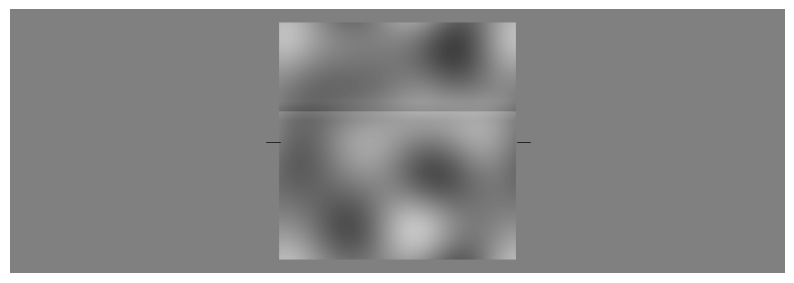

In [139]:
# Original paradigm: Different noise instances
s1 = np.roll(edges[1] + noises[4] - mean_lum, -trans_amount, axis=0)
s1 = np.pad(s1, ((10, 10), (200, 200)), "constant", constant_values=mean_lum)

plt.figure(figsize=(10, 4))
plt.imshow(s1, cmap='gray', vmin=0, vmax=200), plt.axis("off")
plt.plot([190, 200], [s1.shape[0]/2, s1.shape[0]/2], 'k', lw=0.5)
plt.plot([s1.shape[1]-200, s1.shape[1]-190], [s1.shape[0]/2, s1.shape[0]/2], 'k', lw=0.5)
plt.savefig('example_original.png', dpi=300, bbox_inches='tight')
plt.show()

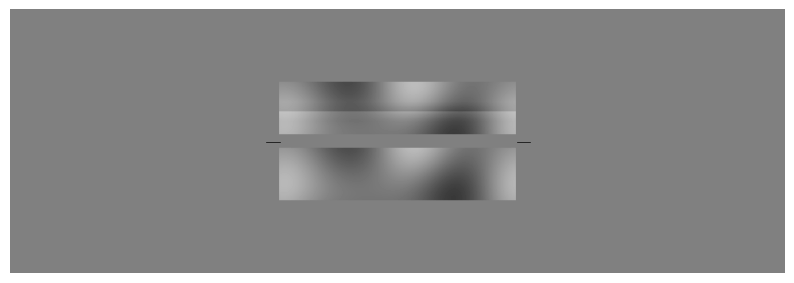

In [138]:
# Control paradigm: Same noise instances
sSize = edges[1].shape[0]
hSize = int(sSize / 2)
fullSize = int(trans_amount * 2)
s2 = np.zeros([sSize, sSize]) + mean_lum
s2[hSize-fullSize:hSize, :] += noises[4][0:fullSize, :] - noises[4][0:fullSize, :].mean()
s2[hSize:hSize+fullSize, :] += noises[4][0:fullSize, :] - noises[4][0:fullSize, :].mean()
s2[hSize-5:hSize+5] = mean_lum
s2[hSize-fullSize:hSize, :] += edges[1][hSize-int(fullSize/2):hSize+int(fullSize/2), :] - mean_lum
s2 = np.pad(s2, ((10, 10), (200, 200)), "constant", constant_values=mean_lum)


plt.figure(figsize=(10, 4))
plt.imshow(s2, cmap='gray', vmin=0, vmax=200), plt.axis("off")
plt.plot([190, 200], [s1.shape[0]/2, s1.shape[0]/2], 'k', lw=0.5)
plt.plot([s1.shape[1]-200, s1.shape[1]-190], [s1.shape[0]/2, s1.shape[0]/2], 'k', lw=0.5)
plt.savefig('example_control.png', dpi=300, bbox_inches='tight')
plt.show()

## Temporal fading

In [10]:
pps = 130
Tfade = int(eparams["stimfading"] * pps)  # Time for fading (in+out)
Tfull = int(eparams["stim_time"] * pps)   # Time at full contrast
T = Tfade + Tfull

def temporal_profile(T_hanning, T_stim):
    hann = np.hanning(T_hanning)
    Th = int(T_hanning/2.)
    tprof = np.concatenate([hann[0:Th], np.ones(T_stim), hann[Th::]])
    return tprof

hann = np.hanning(Tfade)
tsign = temporal_profile(Tfade, Tfull)

hann_fft = np.abs(np.fft.fftshift(np.fft.fft(hann)))**2.
tsign_fft = np.abs(np.fft.fftshift(np.fft.fft(tsign)))**2.

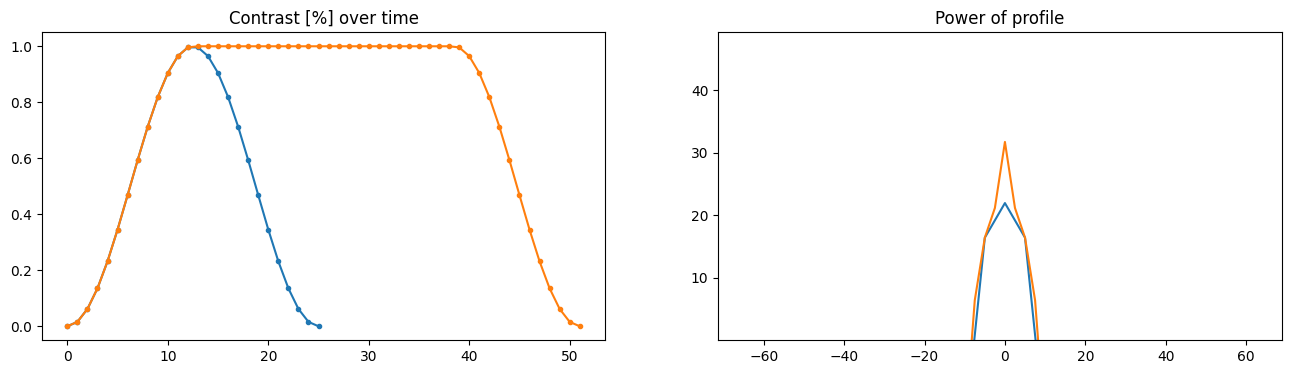

Temporal frequency of the signal: 5.0 Hz


In [11]:
# Plotting
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(hann, '.-')
plt.plot(tsign, '.-')
plt.title('Contrast [%] over time')

plt.subplot(122)
plt.plot(np.fft.fftshift(np.fft.fftfreq(Tfade, d=1./pps)), 10.*np.log10(hann_fft))
plt.plot(np.fft.fftshift(np.fft.fftfreq(T, d=1./pps)),  10.*np.log10(tsign_fft))
plt.title('Power of profile'), plt.ylim(1e-5)
plt.show()

tf_sign = calc_mean_tf(tsign, pps)
print('Temporal frequency of the signal: ' + str(np.round(tf_sign, 4)) + ' Hz')

In [12]:
# Display video with fading signal
show_video = False
if show_video:
    vid_arr = np.expand_dims(edge1 - edge1.mean(), -1) * np.expand_dims(tsign, [0,1]) + edge1.mean()

    %matplotlib notebook
    anim = show_video(vid_arr)
    plt.show()

In [13]:
# Back to inline- plotting
%matplotlib inline

# Spectral analysis

## Calculate and plot power spectra

### Two-dimensional spectra

In [14]:
# Calculate power spectra of noise masks
Nonoise_power = spectral_power(Nonoise) / np.size(Nonoise)
Wnoise_power = spectral_power(Wnoise) / np.size(Nonoise)
Pnoise1_power = spectral_power(Pnoise1) / np.size(Nonoise)
Pnoise2_power = spectral_power(Pnoise2) / np.size(Nonoise)
Nnoise1_power = spectral_power(Nnoise1) / np.size(Nonoise)
Nnoise2_power = spectral_power(Nnoise2) / np.size(Nonoise)
Nnoise3_power = spectral_power(Nnoise3) / np.size(Nonoise)
noise_powers = [Nonoise_power, Wnoise_power, Pnoise1_power, Pnoise2_power, Nnoise1_power, Nnoise2_power, Nnoise3_power]

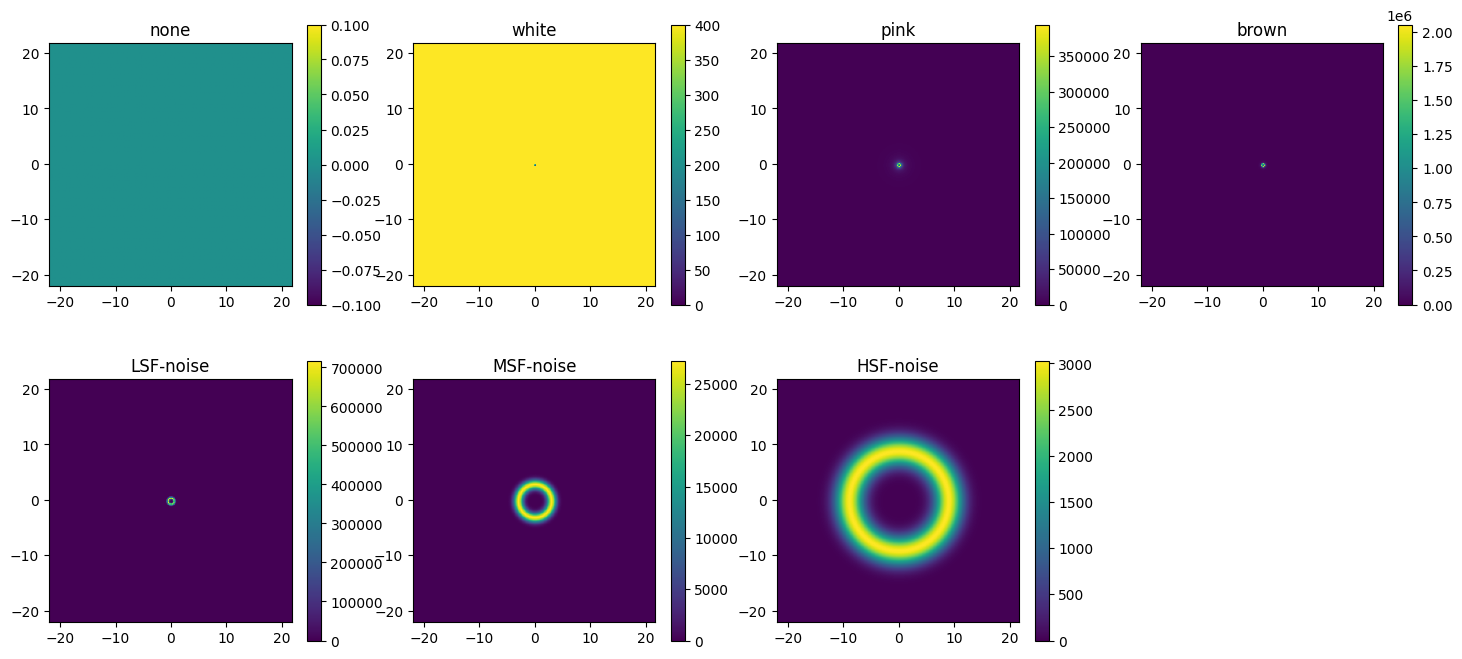

In [15]:
# Plot noise spectra
n, m = 2, 4
plt.figure(figsize=(18, 8))
for i in range(len(noises)):
    plt.subplot(n, m, i+1)
    plt.imshow(noise_powers[i], extent=fextent)
    plt.title(noise_types[i]), plt.colorbar()
plt.show()

In [16]:
# Calculate power spectra of edge stimulus + noise masks
edge1_power = spectral_power(edge1) / np.size(Nonoise)
edge2_power = spectral_power(edge2) / np.size(Nonoise)
edge3_power = spectral_power(edge3) / np.size(Nonoise)
edge_powers = [edge1_power, edge2_power, edge3_power]

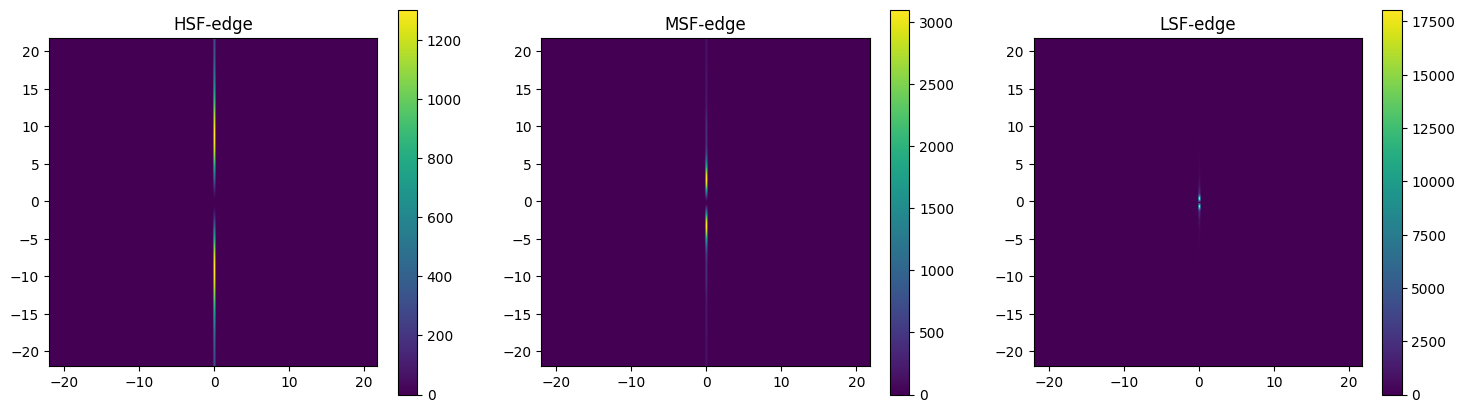

In [17]:
# Plot all edge spectra
n, m = 1, 3
plt.figure(figsize=(18, 5))
for i in range(len(edge_powers)):
    plt.subplot(n, m, i+1), plt.imshow(edge_powers[i], extent=fextent), plt.title(edge_types[i]), plt.colorbar()
plt.show()

### power spectra (visualization-purposes)
We do this just for visualization purposes because it is more correct to do all computations with the 2d spectra.

Side-note: If we just take the 1d spectra (either radially averaged or cut-through), then the resulting spectra are not equal in power anymore.

Explanation: the arrays are squared and not circular

In [18]:
# Get horizontal cut-through power
if rotate:
    edge1_power_1d = edge1_power[int(nX/2)::, int(nX/2)]
    edge2_power_1d = edge2_power[int(nX/2)::, int(nX/2)]
    edge3_power_1d = edge3_power[int(nX/2)::, int(nX/2)]
else:
    edge1_power_1d = edge1_power[int(nX/2), int(nX/2)::]
    edge2_power_1d = edge2_power[int(nX/2), int(nX/2)::]
    edge3_power_1d = edge3_power[int(nX/2), int(nX/2)::]

Nonoise_power_1d = Nonoise_power[int(nX/2), int(nX/2)::]
Wnoise_power_1d = Wnoise_power[int(nX/2), int(nX/2)::]
Pnoise1_power_1d = Pnoise1_power[int(nX/2), int(nX/2)::]
Pnoise2_power_1d = Pnoise2_power[int(nX/2), int(nX/2)::]
Nnoise1_power_1d = Nnoise1_power[int(nX/2), int(nX/2)::]
Nnoise2_power_1d = Nnoise2_power[int(nX/2), int(nX/2)::]
Nnoise3_power_1d = Nnoise3_power[int(nX/2), int(nX/2)::]

# Make list for plotting:
edge_powers_1d = [edge1_power_1d, edge2_power_1d, edge3_power_1d]
noise_powers_1d = [Nonoise_power_1d, Wnoise_power_1d, Pnoise1_power_1d, Pnoise2_power_1d, \
                   Nnoise1_power_1d, Nnoise2_power_1d, Nnoise3_power_1d]

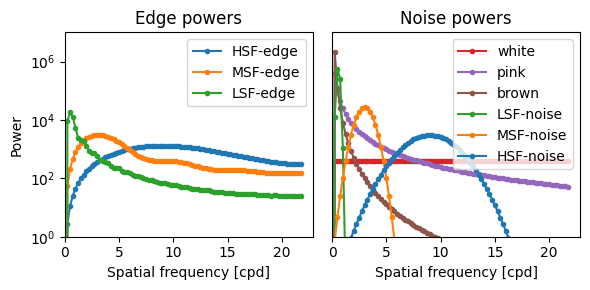

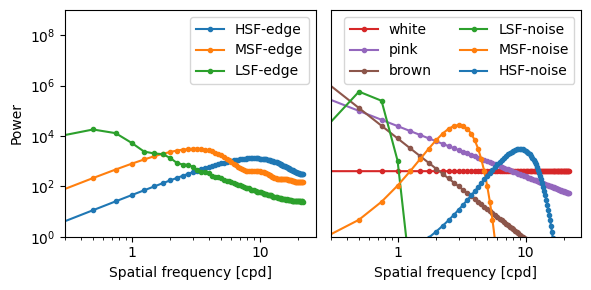

In [19]:
npowers = noise_powers_1d[1::]
ntitles = noise_types[1::]
noise_colors = ["C3", "C4", "C5", "C2", "C1", "C0"]

# Plot 1d-spectra
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i in range(len(edge_powers)):
    axes[0].plot(fs_1d, edge_powers_1d[i], '.-', label=edge_types[i])
for i in range(len(npowers)):
    axes[1].plot(fs_1d, npowers[i], '.-', label=ntitles[i], color=noise_colors[i])
axes[0].set(xlabel='Spatial frequency [cpd]', yscale='log', ylim=(1, 1e7), xlim=(0.), ylabel='Power', title='Edge powers')
axes[0].legend()
axes[1].set(xlabel='Spatial frequency [cpd]', yscale='log', ylim=(1, 1e7), xlim=(0.), yticks=(), title='Noise powers')
axes[1].legend()
plt.tight_layout()
plt.show()

# Plot 1d-spectra (log x-axis)
fig, axes = plt.subplots(1, 2, figsize=(6.2, 3))
for i in range(len(edge_powers)):
    axes[0].plot(fs_1d, edge_powers_1d[i], '.-', label=edge_types[i])
for i in range(len(npowers)):
    axes[1].plot(fs_1d, npowers[i], '.-', label=ntitles[i], color=noise_colors[i])
axes[0].set(xlabel='Spatial frequency [cpd]', ylabel='Power', yscale='log', ylim=(1, 1e9),
            xscale='log', xticks=(0.2, 1, 10), xticklabels=(0.2, 1, 10), xlim=(0.3)), axes[0].legend()
axes[1].set(xlabel='Spatial frequency [cpd]', yscale='log', ylim=(1, 1e9), yticks=(),
            xscale='log', xticks=(0.2, 1, 10), xticklabels=(0.2, 1, 10), xlim=(0.3)), axes[1].legend(ncol=2)
plt.tight_layout()
#plt.savefig('1d_powers.png', dpi=300)
plt.show()

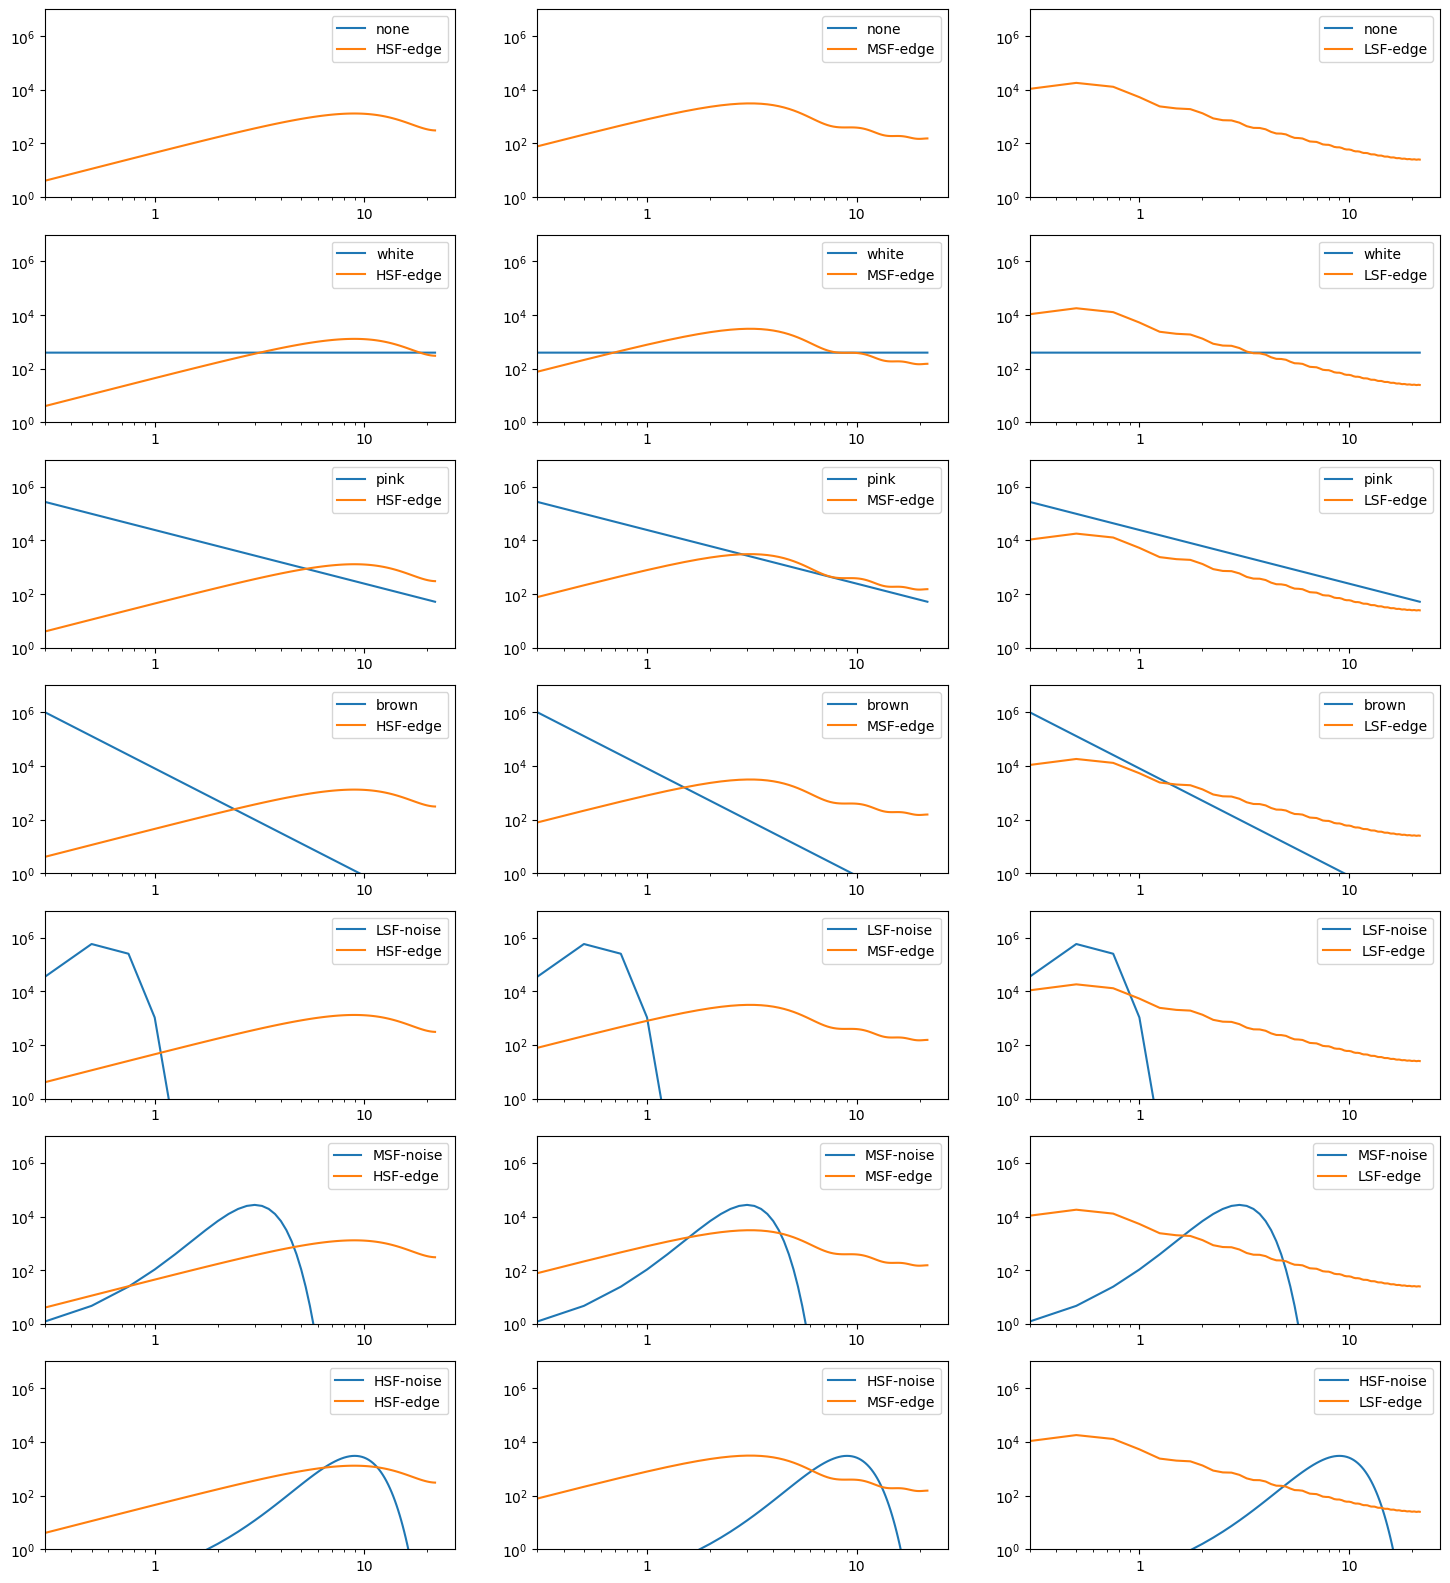

In [20]:
# Plot 1d-spectra (log x-axis)
fig, axes = plt.subplots(len(noises), len(edges), figsize=(18, 20))
for i in range(len(noise_powers)):
    for j in range(len(edge_powers)):
        axes[i, j].plot(fs_1d, noise_powers_1d[i], label=noise_types[i])
        axes[i, j].plot(fs_1d, edge_powers_1d[j], label=edge_types[j])
        axes[i, j].set(yscale='log', ylim=(1, 1e7), xscale='log', xticks=(0.2, 1, 10),
                       xticklabels=(0.3, 1, 10), xlim=(0.3)), axes[i, j].legend()
plt.show()

## Controls

### Peak frequencies
Control that the peak frequencies of the edges and narrowband noises are as desired.

In [21]:
print('Peak SF for edge 1: ' + str(fs_1d[np.argmax(edge1_power_1d)]) + ' cpd')
print('Peak SF for edge 2: ' + str(fs_1d[np.argmax(edge2_power_1d)]) + ' cpd')
print('Peak SF for edge 3: ' + str(fs_1d[np.argmax(edge3_power_1d)]) + ' cpd')
print()
print('Peak SF for narrow noise 1: ' + str(fs_1d[np.argmax(Nnoise1_power_1d)]) + ' cpd')
print('Peak SF for narrow noise 2: ' + str(fs_1d[np.argmax(Nnoise2_power_1d)]) + ' cpd')
print('Peak SF for narrow noise 3: ' + str(fs_1d[np.argmax(Nnoise3_power_1d)]) + ' cpd')

Peak SF for edge 1: 9.0 cpd
Peak SF for edge 2: 3.0 cpd
Peak SF for edge 3: 0.5 cpd

Peak SF for narrow noise 1: 0.5 cpd
Peak SF for narrow noise 2: 3.0 cpd
Peak SF for narrow noise 3: 9.0 cpd


### Signal-to-noise ratios
Control that all edges and all noises have equal power.

In [22]:
# Remove no-noise condition (no power = division by zero):
npowers = noise_powers[1::]
ntitles = noise_types[1::]

# Calculate signal-to-noise ratios between edges and noise masks
snrs = np.zeros([len(edge_powers), len(npowers)])

for i in range(len(edge_powers)):
    for j in range(len(npowers)):
        snrs[i, j] = edge_powers[i].mean() / npowers[j].mean()

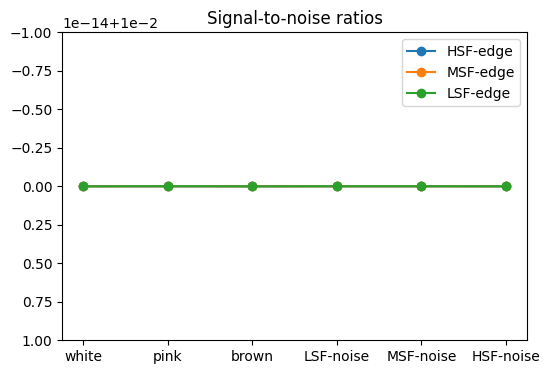

In [23]:
# Plotting
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
for i in range(len(edge_powers)):
    axes.plot(ntitles, snrs[i, :], 'o-', label=edge_types[i])
axes.set(title='Signal-to-noise ratios'), axes.legend()
if not plot_sensitivity:
    axes.invert_yaxis()
plt.show()

# Data visualizations

## Load experimental data

In [24]:
vps = ["ls", "mm", "jv", "ga", "sg", "fd"]
n_vps = len(vps)

datadir = "../experiment/results/"
data = load_all_data(datadir, vps)
data

,trial,noise,noise_contrast,edge_contrast,edge_width,mean_lum,stim_time,rotID,transID,maskID,resp,correct,resptime,dropframes,session,vp
0,0,white,0.2,0.009378,0.150,100.0,0.2,0,1,21,1,1,0.01716,0,0,0
1,1,white,0.2,0.009378,0.150,100.0,0.2,0,1,3,1,1,0.03233,0,0,0
2,2,white,0.2,0.003133,0.150,100.0,0.2,0,1,3,1,1,0.34839,0,0,0
3,3,white,0.2,0.012500,0.150,100.0,0.2,0,1,14,1,1,0.00314,0,0,0
4,4,white,0.2,0.009378,0.150,100.0,0.2,0,1,6,1,1,0.00073,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,95,none,0.2,0.003000,0.048,100.0,0.2,1,0,5,0,1,0.11295,0,1,5
4196,96,none,0.2,0.003000,0.048,100.0,0.2,1,1,34,1,1,0.11369,0,1,5
4197,97,none,0.2,0.002253,0.048,100.0,0.2,0,1,17,1,1,0.15488,0,1,5
4198,98,none,0.2,0.000010,0.048,100.0,0.2,1,0,14,1,0,0.13958,0,1,5


In [25]:
noise_conds = np.unique(data["noise"])
edge_conds = np.unique(data["edge_width"])
n_noises = len(noise_conds)
n_edges = len(edge_conds)

print(noise_conds)
print(edge_conds)

['narrow0.5' 'narrow3' 'narrow9' 'none' 'pink1' 'pink2' 'white']
[0.048 0.15  0.95 ]


In [26]:
# Re-structure noise conditions
noise_conds = [noise_conds[3], noise_conds[6], noise_conds[4], noise_conds[5],
               noise_conds[0], noise_conds[1], noise_conds[2]]
print(noise_conds)

['none', 'white', 'pink1', 'pink2', 'narrow0.5', 'narrow3', 'narrow9']


In [27]:
# print number of trials per participant
for i in range(n_vps):
    print(vps[i], data["vp"].value_counts()[i])

ls 4200
mm 4200
jv 4200
ga 4200
sg 4200
fd 4200


## Set psignifit parameters + run psignifit

In [28]:
# Set parameters for psignifit
options = {
    "sigmoidName": "norm",
    "expType": "2AFC",
}

### Run psignifit for individual data per session (takes quite a while)

In [29]:
vp_list = list(np.arange(n_vps))
res_ind = []

# We will append the dictionaries that psignifit outputs in a list
for ni, n in enumerate(noise_conds):
    for ei, e in enumerate(edge_conds[::-1]):
        for vp in range(len(vp_list)):
            # get data separately for each session (reverse edge order to start with LSF edge)
            for s in range(2):
                psignifit_data = reformat_data(data, n, e, vp_list[vp], s)
                res_ind.append(ps.psignifit(psignifit_data, options))

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

### Run psignifit for pooled data (takes a shorter while)

In [30]:
res_all = []

# We will append the dictionaries that psignifit outputs in a list
for ni, n in enumerate(noise_conds):
    for ei, e in enumerate(edge_conds[::-1]):
        psignifit_data = reformat_data_all(data, n, e)
        res_all.append(ps.psignifit(psignifit_data, optionsIn={**options, "nblocks": psignifit_data.shape[0]/5}))

/home/lynnschmittwilken/python3/lib/python3.11/site-packages/psignifit/psignifit.py:237: UserWarning: psignifit:pooling
We pooled your data, to avoid problems with n=1 blocks or to save time fitting because you have a lot of blocks
You can force acceptance of your blocks by increasing options.nblocks
  warnings.warn('psignifit:pooling\n'\


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


## Plot psychometric curves

/home/lynnschmittwilken/python3/lib/python3.11/site-packages/psignifit/psignifit.py:713: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


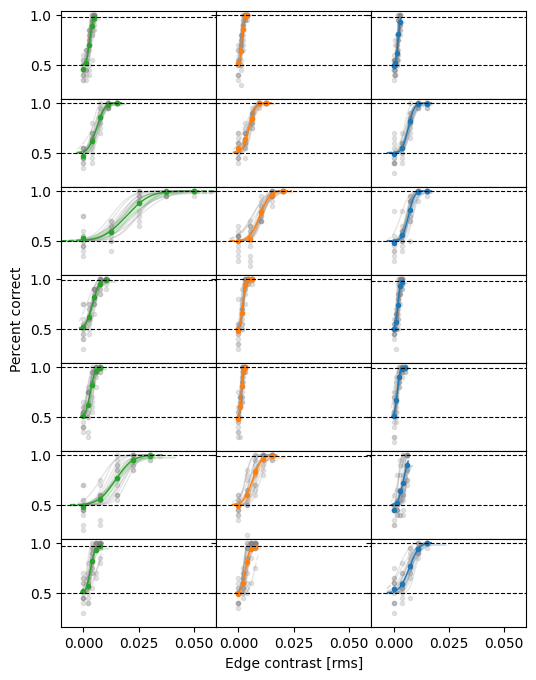

In [31]:
colors = ["C2", "C1", "C0"]

fig, axes = plt.subplots(n_noises, n_edges, figsize=(6, 8), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.001, hspace=0.001)

# Plot individual curves
counter = 0
for n in range(n_noises):
    for e in range(n_edges):
        for vp in range(len(vp_list)):
            for s in range(2):
                plotPsych(res_ind[counter], color="gray", axisHandle=axes[n, e], alpha=0.2, xlim=(-0.01, 0.06))
                counter += 1

# Plot pooled curves
counter = 0
for n in range(n_noises):
    for e in range(n_edges):
        plotPsych(res_all[counter], color=colors[e], axisHandle=axes[n, e], plotAsymptote=True, plotCI=True, xlim=(-0.01, 0.06))
        counter +=1


axes[3, 0].set(ylabel="Percent correct")
axes[n_noises-1, 1].set(xlabel="Edge contrast [rms]")
#plt.savefig('psychocurves_.png', dpi=600)
plt.show()

## Get and plot thresholds (75% performance)

In [32]:
# Get thresholds for individual data
threshInd = np.zeros([len(vp_list), n_noises, n_edges, 2])

counter = 0
for n in range(n_noises):
    for e in range(n_edges):
        for vp in range(len(vp_list)):
            for s in range(2):
                [tTemp, CITemp] = ps.getThreshold(res_ind[counter], 0.75)  # res, pc
                threshInd[vp, n, e, s] = tTemp
                counter += 1


# Get thresholds + CIs for pooled data
threshAll = np.zeros([n_noises, n_edges])
CIAll = np.zeros(np.append(threshAll.shape, 2))

counter = 0
for n in range(n_noises):
    for e in range(n_edges):
        [tTemp, CITemp] = ps.getThreshold(res_all[counter], 0.75)  # res, pc
        threshAll[n, e] = tTemp
        CIAll[n, e, :] = CITemp[0, :] # 0:95%, 1:90%, 2:68%
        counter += 1

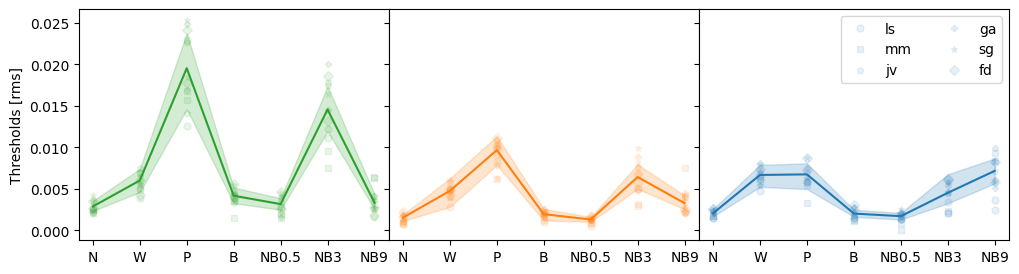

In [33]:
# Plot thresholds
fig, axes = plt.subplots(1, n_edges, figsize=(12, 3), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.001, hspace=0.001)

titles = ["N", "W", "P", "B", "NB0.5", "NB3", "NB9"]
markers = ["o", "s", "p", "P", "*", "D"]
plot_params = {"linestyle": "None", "alpha": 0.1, "markersize": 5}

for e in range(n_edges):
    for s in range(2):
        for i in range(len(vp_list)):
            if (e==2) & (s==0):
                axes[e].plot(titles, threshInd[i, :, e, s], colors[e], marker=markers[i], **plot_params, label=vps[i])
            else:
                axes[e].plot(titles, threshInd[i, :, e, s], colors[e], marker=markers[i], **plot_params)
    axes[e].plot(titles, threshAll[:, e], colors[e])
    axes[e].fill_between(np.arange(n_noises), CIAll[:, e, 0], CIAll[:, e, 1], color=colors[e], alpha=0.2)
axes[0].set(ylabel="Thresholds [rms]")
axes[2].legend(ncol=2)

#plt.savefig('thresholds_.png', dpi=300)
plt.show()

## Print lapse rates of pooled data

In [34]:
# The order of ["Fit"] is [threshold,width,lambda,gamma,eta]
counter = 0
for n in range(n_noises):
    for e in range(n_edges):
        lamb = np.round(res_all[counter]["Fit"][2] * 100, 3)
        print("Lapse rate for " + str(edge_conds[n_edges-e-1]) + noise_conds[n], "=", lamb, "%")
        counter += 1

Lapse rate for 0.95none = 1.79 %
Lapse rate for 0.15none = 0.314 %
Lapse rate for 0.048none = 1.823 %
Lapse rate for 0.95white = 0.0 %
Lapse rate for 0.15white = 0.0 %
Lapse rate for 0.048white = 0.701 %
Lapse rate for 0.95pink1 = 0.536 %
Lapse rate for 0.15pink1 = 0.0 %
Lapse rate for 0.048pink1 = 0.313 %
Lapse rate for 0.95pink2 = 0.885 %
Lapse rate for 0.15pink2 = 0.545 %
Lapse rate for 0.048pink2 = 2.305 %
Lapse rate for 0.95narrow0.5 = 0.555 %
Lapse rate for 0.15narrow0.5 = 0.615 %
Lapse rate for 0.048narrow0.5 = 0.918 %
Lapse rate for 0.95narrow3 = 0.563 %
Lapse rate for 0.15narrow3 = 0.732 %
Lapse rate for 0.048narrow3 = 0.0 %
Lapse rate for 0.95narrow9 = 3.501 %
Lapse rate for 0.15narrow9 = 3.611 %
Lapse rate for 0.048narrow9 = 0.0 %


## Plot contrasts from no-noise condition

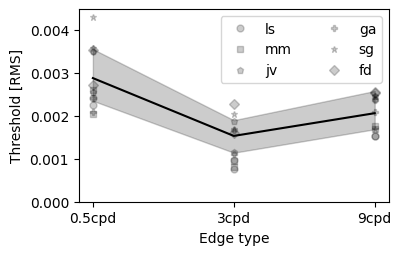

In [35]:
# Plot thresholds
fig, axes = plt.subplots(1, 1, figsize=(4, 2.5), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.001)

titles = ["0.5cpd", "3cpd", "9cpd"]
markers = ["o", "s", "p", "P", "*", "D"]
plot_params = {"linestyle": "None", "alpha": 0.2, "markersize": 5}

for s in range(2):
    for i in range(len(vp_list)):
        if s==0:
            axes.plot(titles, threshInd[i, 0, :, s], "k", marker=markers[i], **plot_params, label=vps[i])
        else:
            axes.plot(titles, threshInd[i, 0, :, s], "k", marker=markers[i], **plot_params)
axes.plot(titles, threshAll[0, :], "k")
axes.fill_between(np.arange(n_edges), CIAll[0, :, 0], CIAll[0, :, 1], color="k", alpha=0.2)
axes.set(ylabel="Threshold [RMS]", xlabel="Edge type", ylim=0)
axes.legend(ncol=2)
plt.show()

### Add Michelson contrast

In [36]:
# Create stimuli wifh RMS contrast thresholds and calculate Michelson contrast
threshAllMC = np.zeros(n_edges)
CIAllMC = np.zeros([n_edges, 2])
for ei in range(n_edges):
    edgeTemp = cornsweet_illusion(nX/ppd, ppd, 'rms', threshAll[0, ei], edge_widths[n_edges-ei-1], edge_exponent, mean_lum)
    threshAllMC[ei] = (edgeTemp.max() - edgeTemp.min()) / (edgeTemp.max() + edgeTemp.min())
    
    edgeTemp = cornsweet_illusion(nX/ppd, ppd, 'rms', CIAll[0, ei, 0], edge_widths[n_edges-ei-1], edge_exponent, mean_lum)
    CIAllMC[ei, 0] = (edgeTemp.max() - edgeTemp.min()) / (edgeTemp.max() + edgeTemp.min())
    
    edgeTemp = cornsweet_illusion(nX/ppd, ppd, 'rms', CIAll[0, ei, 1], edge_widths[n_edges-ei-1], edge_exponent, mean_lum)
    CIAllMC[ei, 1] = (edgeTemp.max() - edgeTemp.min()) / (edgeTemp.max() + edgeTemp.min())

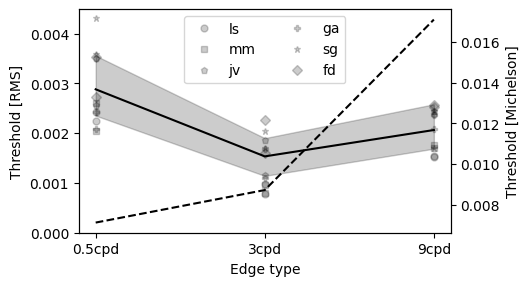

In [37]:
fig, axes = plt.subplots(1, 1, figsize=(4.8, 2.9), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.001)

for s in range(2):
    for i in range(len(vp_list)):
        if s==0:
            axes.plot(titles, threshInd[i, 0, :, s], "k", marker=markers[i], **plot_params, label=vps[i])
        else:
            axes.plot(titles, threshInd[i, 0, :, s], "k", marker=markers[i], **plot_params)
axes.plot(titles, threshAll[0, :], "k")
axes.fill_between(np.arange(n_edges), CIAll[0, :, 0], CIAll[0, :, 1], color="k", alpha=0.2)
axes.set(ylabel="Threshold [RMS]", xlabel="Edge type", ylim=0)

ax2 = axes.twinx()
ax2.plot(titles, threshAllMC, "k--")
ax2.set_ylabel("Threshold [Michelson]")

axes.legend(ncol=2, loc='upper center')
#plt.savefig('thresholds_nonoise.png', dpi=300)
plt.show()

## Plot threshold elevations

### Channel-specific interference (narrowband noises)

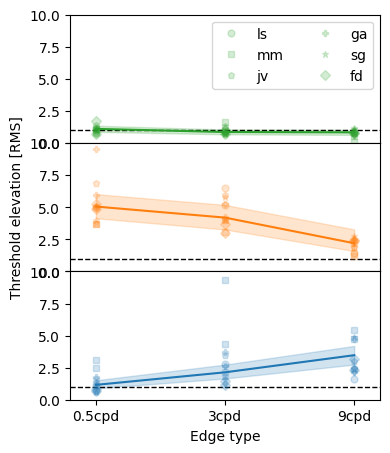

In [38]:
# Plot thresholds
fig, axes = plt.subplots(3, 1, figsize=(4, 5), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.001)

titles = ["0.5cpd", "3cpd", "9cpd"]
titles2 = ["NB0.5", "NB3", "NB9"]
markers = ["o", "s", "p", "P", "*", "D"]
plot_params = {"linestyle": "None", "alpha": 0.2, "markersize": 5}

for n in range(4, n_noises):
    axes[n-4].plot([-0.2, 2.2], [1, 1], "k--", linewidth=1)
    for s in range(2):
        for i in range(len(vp_list)):
            if s==0:
                axes[n-4].plot(titles, threshInd[i, n, :, s]/threshInd[i, 0, :, s], noise_colors[n-1], marker=markers[i], **plot_params, label=vps[i])
            else:
                axes[n-4].plot(titles, threshInd[i, n, :, s]/threshInd[i, 0, :, s], noise_colors[n-1], marker=markers[i], **plot_params)
    axes[n-4].plot(titles, threshAll[n, :]/threshAll[0, :], noise_colors[n-1])
    axes[n-4].fill_between(np.arange(n_edges), CIAll[n, :, 0]/threshAll[0, :], CIAll[n, :, 1]/threshAll[0, :], color=noise_colors[n-1], alpha=0.2)
    axes[n-4].set(xlabel="Edge type")
axes[1].set(ylabel="Threshold elevation [RMS]", ylim=[0, 10], xlim=[-0.2, 2.2])
axes[0].legend(ncol=2)

#plt.savefig('elevations_narrowband.png', dpi=300)
plt.show()

### Non-linear interactions (broadband noises)

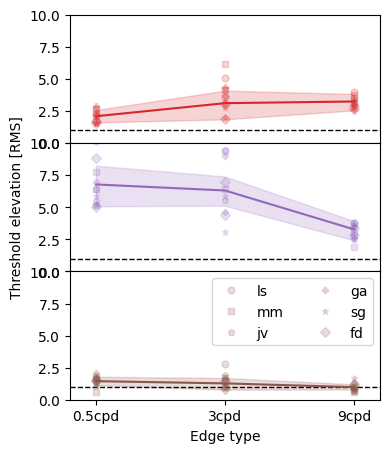

In [39]:
# Plot thresholds
fig, axes = plt.subplots(3, 1, figsize=(4, 5), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.001)

titles = ["0.5cpd", "3cpd", "9cpd"]
titles2 = ["white", "pink", "brown"]
markers = ["o", "s", "p", "P", "*", "D"]
plot_params = {"linestyle": "None", "alpha": 0.2, "markersize": 5}

for n in range(1, 4):
    axes[n-1].plot([-0.2, 2.2], [1, 1], "k--", linewidth=1)
    for s in range(2):
        for i in range(len(vp_list)):
            if s==0:
                axes[n-1].plot(titles, threshInd[i, n, :, s]/threshInd[i, 0, :, s], noise_colors[n-1], marker=markers[i], **plot_params, label=vps[i])
            else:
                axes[n-1].plot(titles, threshInd[i, n, :, s]/threshInd[i, 0, :, s], noise_colors[n-1], marker=markers[i], **plot_params)
    axes[n-1].plot(titles, threshAll[n, :]/threshAll[0, :], noise_colors[n-1])
    axes[n-1].fill_between(np.arange(n_edges), CIAll[n, :, 0]/threshAll[0, :], CIAll[n, :, 1]/threshAll[0, :], color=noise_colors[n-1], alpha=0.2)
    axes[n-1].set(xlabel="Edge type")
axes[1].set(ylabel="Threshold elevation [RMS]", ylim=[0, 10], xlim=[-0.2, 2.2])
axes[2].legend(ncol=2)

#plt.savefig('elevations_broadband.png', dpi=300)
plt.show()

# Comparison of power spectra

## Correlation

In [40]:
# Calculate correlation between power of edges and noise masks
corrs = np.zeros([len(edge_powers), len(npowers)])

for i in range(len(edge_powers)):
    for j in range(len(npowers)):
        corrs[i, j] = np.corrcoef(edge_powers[i].flatten(), npowers[j].flatten())[0, 1]

## Mean product

Very similar to ideal-observer-like analysis below.

In [41]:
# Get overlap between spectra
overlap = np.zeros([len(edge_powers), len(npowers)])

for i in range(len(edge_powers)):
    for j in range(len(npowers)):
        overlap[i, j] = np.mean(edge_powers[i] * npowers[j])

## Ideal observer
The "ideal observer" which is most sensitive to the edge stimulus would have a sensitivity function which is equal to be edge power spectrum.

In [42]:
ideal_edge = np.zeros([len(edge_powers), 1, nX, nX])
ideal_noise = np.zeros([len(edge_powers), len(npowers), nX, nX])

# Calculate ideal observer response to edge:
for i in range(len(edge_powers)):
    ideal_edge[i, 0, :, :] = edge_powers[i]**2.

# Calculate ideal observer response to noise:
for i in range(len(edge_powers)):
    for j in range(len(npowers)):
        ideal_noise[i, j, :, :] = edge_powers[i] * npowers[j]

# Calculate signal-to-noise ratios:
ideal_snrs = ideal_edge.mean(axis=(2, 3)) / ideal_noise.mean(axis=(2, 3))

## Plot data + similarity indices together

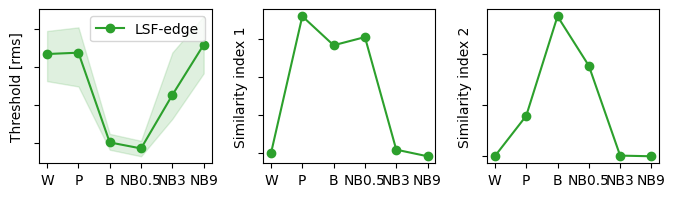

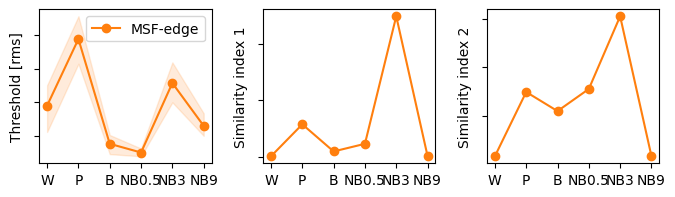

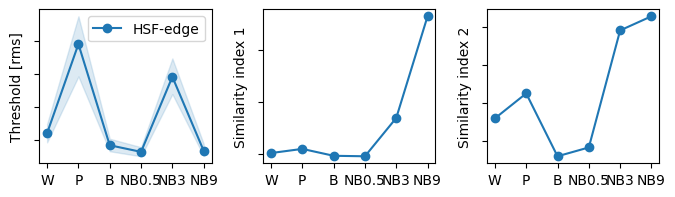

In [43]:
titles = ["W", "P", "B", "NB0.5", "NB3", "NB9"]

# HSF edge
i = 2
fig, axes = plt.subplots(1, 3, figsize=(8, 2), sharex=True)
fig.subplots_adjust(wspace=0.3)
axes[0].plot(titles, threshAll[1:, i], "o-", label=edge_types[i], color="C2")
axes[0].fill_between(np.arange(n_noises-1), CIAll[1:, i, 0], CIAll[1:, i, 1], color="C2", alpha=0.15)
axes[0].legend()
axes[0].set(ylabel="Threshold [rms]", yticklabels=[])
axes[1].plot(titles, corrs[i, :], 'o-', label=edge_types[i], color="C2")
axes[1].set(ylabel="Similarity index 1", yticklabels=[])
axes[2].plot(titles, overlap[i, :], 'o-', label=edge_types[i], color="C2")
axes[2].set(ylabel="Similarity index 2", yticklabels=[])
axes[2].minorticks_off()
#plt.savefig('similarity_hsf.png', dpi=300)
plt.show()

# MSF edge
i = 1
fig, axes = plt.subplots(1, 3, figsize=(8, 2), sharex=True)
fig.subplots_adjust(wspace=0.3)
axes[0].plot(titles, threshAll[1:, i], "o-", label=edge_types[i], color="C1")
axes[0].fill_between(np.arange(n_noises-1), CIAll[1:, i, 0], CIAll[1:, i, 1], color="C1", alpha=0.15)
axes[0].legend()
axes[0].set(ylabel="Threshold [rms]", yticklabels=[])
axes[1].plot(titles, corrs[i, :], 'o-', label=edge_types[i], color="C1")
axes[1].set(ylabel="Similarity index 1", yticklabels=[])
axes[2].plot(titles, overlap[i, :], 'o-', label=edge_types[i], color="C1")
axes[2].set(ylabel="Similarity index 2", yticklabels=[])
axes[2].minorticks_off()
#plt.savefig('similarity_hsf.png', dpi=300)
plt.show()

# LSF edge
i = 0
fig, axes = plt.subplots(1, 3, figsize=(8, 2), sharex=True)
fig.subplots_adjust(wspace=0.3)
axes[0].plot(titles, threshAll[1:, i], "o-", label=edge_types[i], color="C0")
axes[0].fill_between(np.arange(n_noises-1), CIAll[1:, i, 0], CIAll[1:, i, 1], color="C0", alpha=0.15)
axes[0].legend()
axes[0].set(ylabel="Threshold [rms]", yticklabels=[])
axes[1].plot(titles, corrs[i, :], 'o-', label=edge_types[i], color="C0")
axes[1].set(ylabel="Similarity index 1", yticklabels=[])
axes[2].plot(titles, overlap[i, :], 'o-', label=edge_types[i], color="C0")
axes[2].set(ylabel="Similarity index 2", yticklabels=[])
axes[2].minorticks_off()
#plt.savefig('similarity_hsf.png', dpi=300)
plt.show()

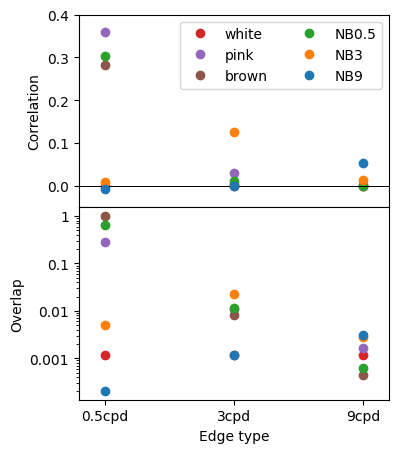

In [44]:
yTicks = (0.001, 0.01, 0.1, 1)

# Plot thresholds
fig, axes = plt.subplots(2, 1, figsize=(4, 5), sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.001)

titles = ["0.5cpd", "3cpd", "9cpd"]
titles2 = ["white", "pink", "brown", "NB0.5", "NB3", "NB9"]
plot_params = {"linestyle": "None", "alpha": 0.2, "markersize": 5}

for n in range(n_noises-1):
    axes[0].plot([-0.2, 2.2], [0, 0], "k-", linewidth=0.5)
    axes[0].plot(titles, corrs[::-1, n], noise_colors[n], label=titles2[n], linestyle="None", marker="o")
    
    axes[1].plot([-0.2, 2.2], [0, 0], "k-", linewidth=0.5)
    axes[1].plot(titles, overlap[::-1, n] / overlap.max(), noise_colors[n], label=titles2[n], linestyle="None", marker="o")
    axes[1].set(xlabel="Edge type")
axes[0].set(ylabel="Correlation", ylim=[-0.05, 0.4], xlim=[-0.2, 2.2])
axes[0].legend(ncol=2)
axes[1].set(ylabel="Overlap", yscale="log", xlim=[-0.2, 2.2], yticks=yTicks, yticklabels=yTicks)

#plt.savefig('similarity.png', dpi=300)
plt.show()

# Model visualizations

## Model architectures

### Single-scale model

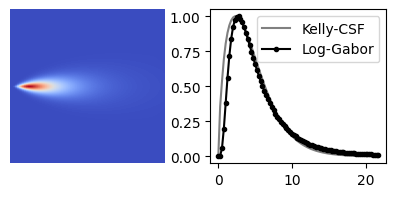

In [45]:
# Create and plot the loggabor filter with the above specifications
loggabor_fft = create_loggabor_fft(fx, fy, 2.64553923, 0.49796013, 0, 0.2965)

# Get Kelly CSF
_, csfSens = st_csf(fs_1d, tf=2.5)

plt.figure(figsize=(5, 2))
plt.subplot(121), plt.imshow(loggabor_fft[:, int(nX/2)::], cmap="coolwarm", extent=fextent), plt.axis("off")

plt.subplot(122)
plt.plot(fs[int(nX/2)::], csfSens / csfSens.max(), "gray", label="Kelly-CSF")
plt.plot(fs[int(nX/2)::], loggabor_fft[int(nX/2), int(nX/2)::], "k.-", label="Log-Gabor")
plt.legend()
#plt.xscale("log"), plt.xlim(0.25)
#plt.savefig('model_singlescale.png', dpi=300)
plt.show()

### Multi-scale model

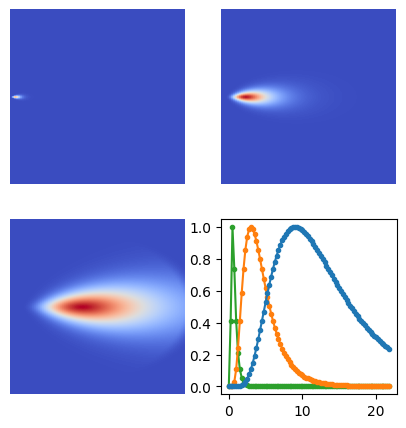

In [46]:
# Create and plot the loggabor filter with the above specifications
loggabor_fft1 = create_loggabor_fft(fx, fy, 0.5, 0.5945, 0, 0.2965)
loggabor_fft2 = create_loggabor_fft(fx, fy, 3., 0.5945, 0, 0.2965)
loggabor_fft3 = create_loggabor_fft(fx, fy, 9., 0.5945, 0, 0.2965)
loggabs = [loggabor_fft1, loggabor_fft2, loggabor_fft3]


plt.figure(figsize=(5, 5))
for i in range(3):
    plt.subplot(2, 2, i+1), plt.imshow(loggabs[i][:, int(nX/2)::], cmap="coolwarm", extent=fextent)
    plt.axis("off")
    plt.subplot(2, 2, 4), plt.plot(fs[int(nX/2)::], loggabs[i][int(nX/2), int(nX/2)::], colors[i], marker=".", label=titles[i])
    #plt.xscale("log"), plt.xlim(0.25)
#plt.savefig('model_multicale.png', dpi=300)
plt.show()

## Naka-Rushtons

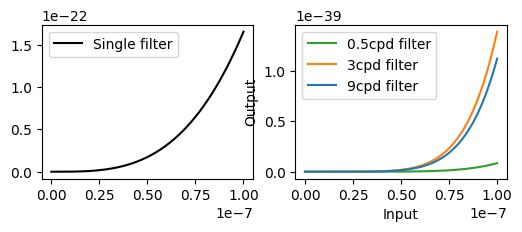

In [47]:
toy_x = np.linspace(0, 0.0000001, 1000)
naka_single = np.squeeze(naka_rushton(toy_x, alpha=1.470567, beta=0.14855648, eta=0.352139, kappa=2.901618))
naka_multi1 = np.squeeze(naka_rushton(toy_x, alpha=0.555503, beta=1.6712e-05, eta=1.045544, kappa=5.164947))
naka_multi2 = np.squeeze(naka_rushton(toy_x, alpha=0.688194, beta=1.6712e-05, eta=1.045544, kappa=5.164947))
naka_multi3 = np.squeeze(naka_rushton(toy_x, alpha=0.042196, beta=1.6712e-05, eta=1.045544, kappa=5.164947))

# Plotting
plt.figure(figsize=(6, 2))
plt.subplot(121), plt.plot(toy_x, naka_single, "k", label="Single filter"), plt.legend()
plt.subplot(122), plt.plot(toy_x, naka_multi3, color=colors[0], label="0.5cpd filter")
plt.subplot(122), plt.plot(toy_x, naka_multi2, color=colors[1], label="3cpd filter")
plt.subplot(122), plt.plot(toy_x, naka_multi1, color=colors[2], label="9cpd filter"), plt.legend()
plt.xlabel("Input"), plt.ylabel("Output")
#plt.savefig('nakas.png', dpi=300)
plt.show()